# Introdução

Nesta análise exploratória, investigamos um conjunto de dados de músicas do Spotify, com o objetivo principal de entender os fatores que influenciam a popularidade das faixas lançadas. A popularidade das músicas é um indicador importante para artistas, gravadoras e plataformas de streaming, pois reflete o engajamento do público.

A análise envolve o estudo das características das músicas, como gênero, idioma, duração, ano de lançamento, além de atributos relacionados a artistas, gravadoras e compositores. Também foram exploradas as tendências temporais da popularidade e o impacto dos artistas novos na indústria musical.

Por fim, foi feita uma tentativa de construir um modelo preditivo para estimar a popularidade das músicas com base nessas características, buscando fornecer uma ferramenta útil para antecipar o sucesso das faixas.


# Importação de Bibliotecas e Configurações Iniciais

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Metodologia

1. **Preparação dos Dados**  
   - Importação e limpeza do dataset, tratamento de valores ausentes, padronização de texto e conversão de datas.  
   - Exploração inicial para verificar duplicatas, valores nulos e distribuição das variáveis principais.  
   - Engenharia de features, como criação de variáveis indicadoras para artistas novos e extração do ano de lançamento.

2. **Análise Exploratória de Dados (EDA)**  
   - Visualização da distribuição dos gêneros musicais, idiomas, gravadoras e artistas com mais músicas.  
   - Análise temporal da popularidade e dos streams médios, assim como a participação crescente ou decrescente de artistas novos.  
   - Análise de correlação entre variáveis numéricas e categóricas, usando codificação adequada para variáveis qualitativas.

3. **Modelagem Preditiva**  
   - Seleção das features relevantes (como idioma, gênero, duração, ano) e transformação por meio de codificação one-hot.  
   - Aplicação de algoritmos de machine learning para prever a popularidade das músicas.  
   - Avaliação dos resultados e identificação dos principais desafios na construção de um modelo robusto.


# Carregamento e Cópia do Conjunto de Dados

In [ ]:
df0 = pd.read_csv("/content/spotify_songs_dataset.csv")
df = df0.copy()

# Visão Geral Inicial do Dataset

In [ ]:
df.sample(n=10)

,song_id,song_title,artist,album,genre,release_date,duration,popularity,stream,language,explicit_content,label,composer,producer,collaboration
673,SP0674,Live two as several.,Michael Schwartz,High.,Pop,2007-04-19,202.0,69,78534448,Spanish,No,Warner Music,Kimberly Brooks,Jeremy Freeman,NaN
49046,SP49047,Suddenly share coach.,Paul Steele,Market.,Folk,2010-06-26,282.0,50,28745688,English,No,Atlantic Records,Wendy Sandoval,Brandy Morales,NaN
159,SP0160,Loss through player.,Yolanda Schultz,Field as.,Pop,1999-08-08,183.0,80,21478058,Italian,No,Sony Music,Bobby Myers,Heather Mcconnell,NaN
37874,SP37875,Care million nothing.,Michael Jackson,Growth provide.,Pop,2021-12-28,253.0,27,34937158,English,Yes,Universal Music,Anthony Shields,Lisa Davis,Anna Baker
17518,SP17519,Threat paper.,Vincent Morgan,Help.,Pop,1999-01-09,237.0,100,44162807,English,No,Universal Music,Brianna Peterson,Hayden Acevedo,NaN
44530,SP44531,Cold certainly.,Mitchell Nunez,Performance.,Hip-Hop,2000-07-21,298.0,37,63752194,English,Yes,Atlantic Records,Jamie Garcia,Kimberly Wheeler,NaN
25734,SP25735,Space none bag.,Shawn Ramirez,Local.,Pop,1999-06-01,215.0,17,8079655,Italian,Yes,Universal Music,Michelle Collins,Cassandra Hernandez,NaN
34585,SP34586,Figure college church.,Darrell Baker,Place international.,Electronic,2000-10-13,263.0,88,38786942,English,Yes,Sony Music,David Miller,Michele Owens,NaN
20549,SP20550,Cost very instead.,Sara Hickman,Less.,Pop,2003-03-15,240.0,59,28311712,English,No,Def Jam,Michael Meyers,Jesse Nelson,NaN
43680,SP43681,Establish fish.,Eric Summers,Marriage.,Hip-Hop,2000-09-17,221.0,58,28305083,German,Yes,Atlantic Records,Michael Stevens,Garrett Brady,NaN


In [ ]:
df.shape

(50000, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           50000 non-null  object 
 1   song_title        50000 non-null  object 
 2   artist            50000 non-null  object 
 3   album             50000 non-null  object 
 4   genre             50000 non-null  object 
 5   release_date      50000 non-null  object 
 6   duration          45000 non-null  float64
 7   popularity        50000 non-null  int64  
 8   stream            50000 non-null  int64  
 9   language          47500 non-null  object 
 10  explicit_content  50000 non-null  object 
 11  label             50000 non-null  object 
 12  composer          50000 non-null  object 
 13  producer          50000 non-null  object 
 14  collaboration     15000 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 5.7+ MB


# Verificação de Dados Duplicados e Valores Ausentes

In [ ]:
df.duplicated().sum()

np.int64(0)

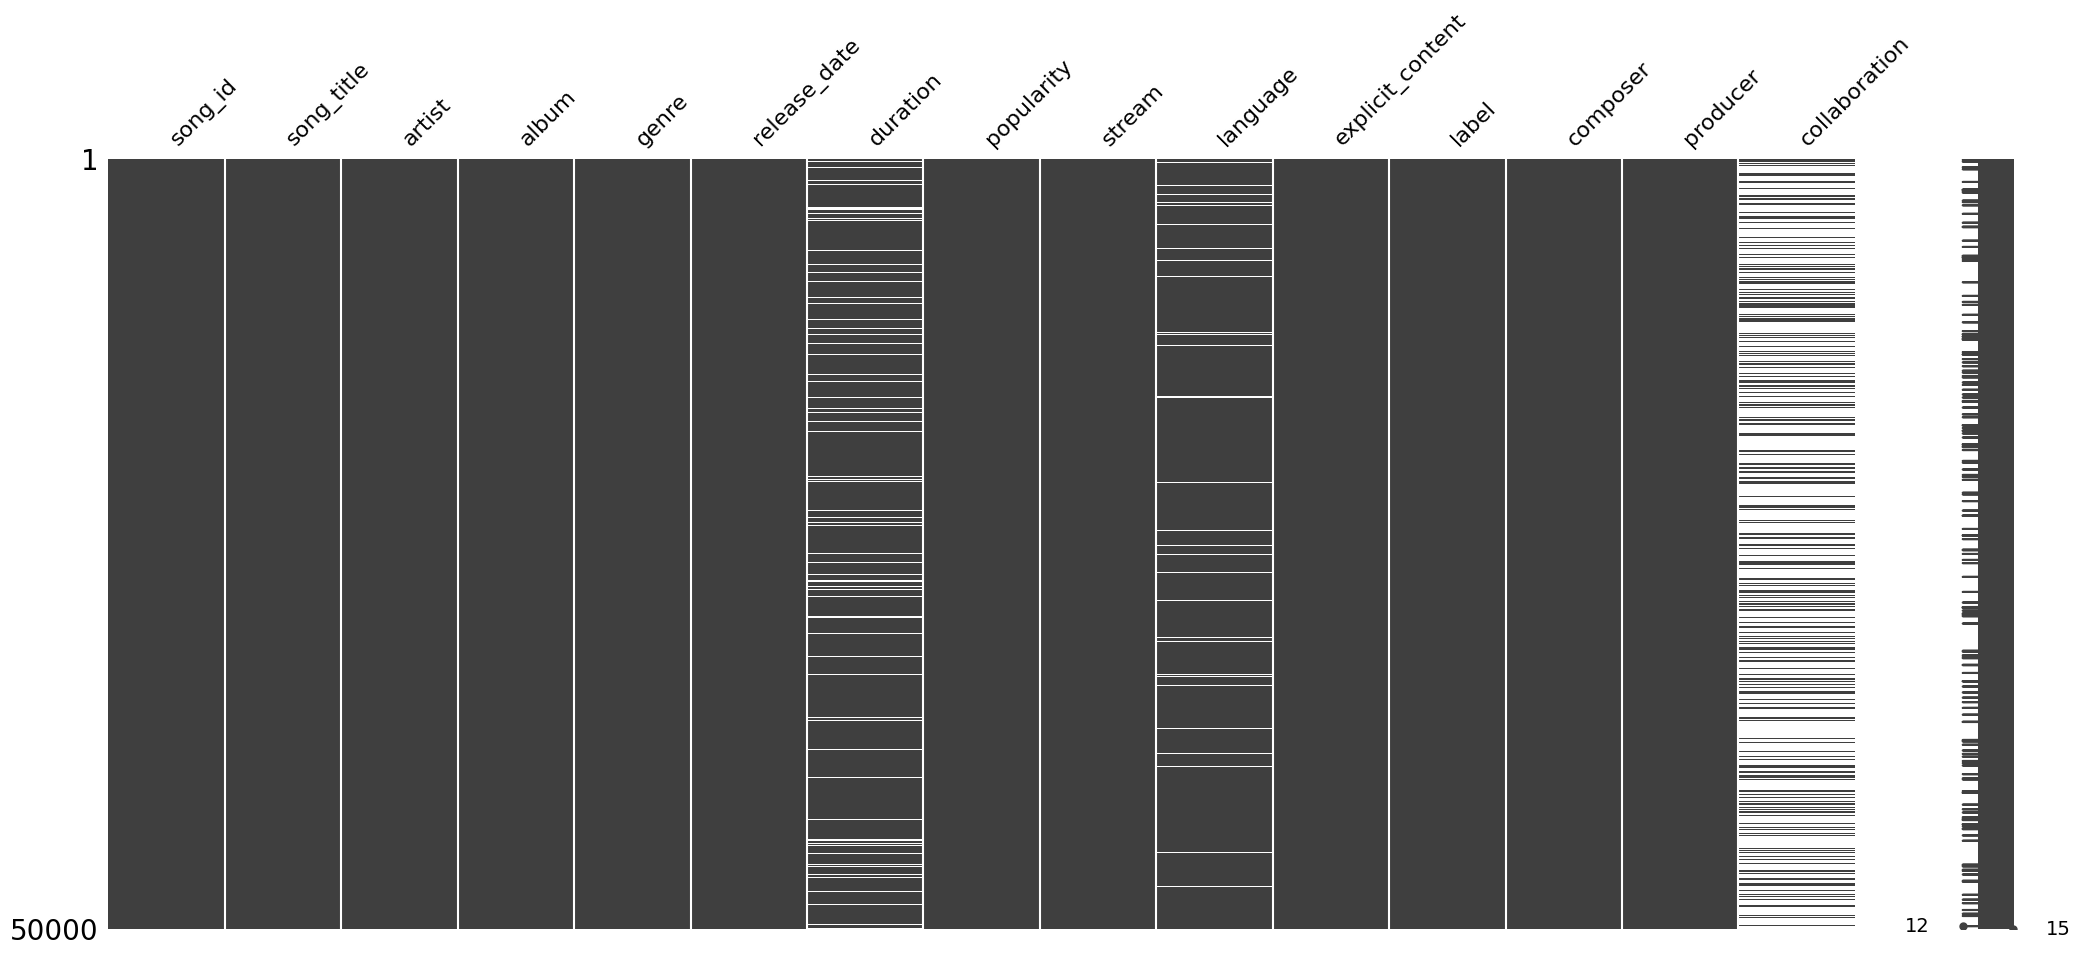

In [ ]:
msno.matrix(df);

# Padronização de Texto e Contagem de Títulos Únicos

In [ ]:
df["song_title"] = df["song_title"].str.title()
df.song_title.nunique()

46396

In [ ]:
df["album"] = df["album"].str.title()

# Tratamento da Coluna de Datas e Identificação dos Anos Mínimo e Máximo

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

max_year = df['release_date'].dt.year.max()

print(f"O maior ano: {max_year}")

O maior ano: 2024


In [ ]:
min_year = df['release_date'].dt.year.min()
print(f"O menor ano é: {min_year}")

O menor ano é: 1994


In [ ]:
df.groupby("genre")["duration"].mean().round(0)

,duration
genre,
Classical,239.0
Country,239.0
Electronic,240.0
Folk,240.0
Hip-Hop,240.0
Jazz,240.0
Pop,239.0
R&B,240.0
Reggae,241.0


# Cálculo da Duração Média por Gênero e Tratamento de Valores Nulos na Coluna de Idioma

In [ ]:
df['duration'] = df.groupby('genre')['duration'].apply(lambda x: x.fillna(x.mean().round(0))).reset_index(level=0, drop=True)

In [ ]:
df['language'] = df.groupby('genre')['language'].apply(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
).reset_index(level=0, drop=True)

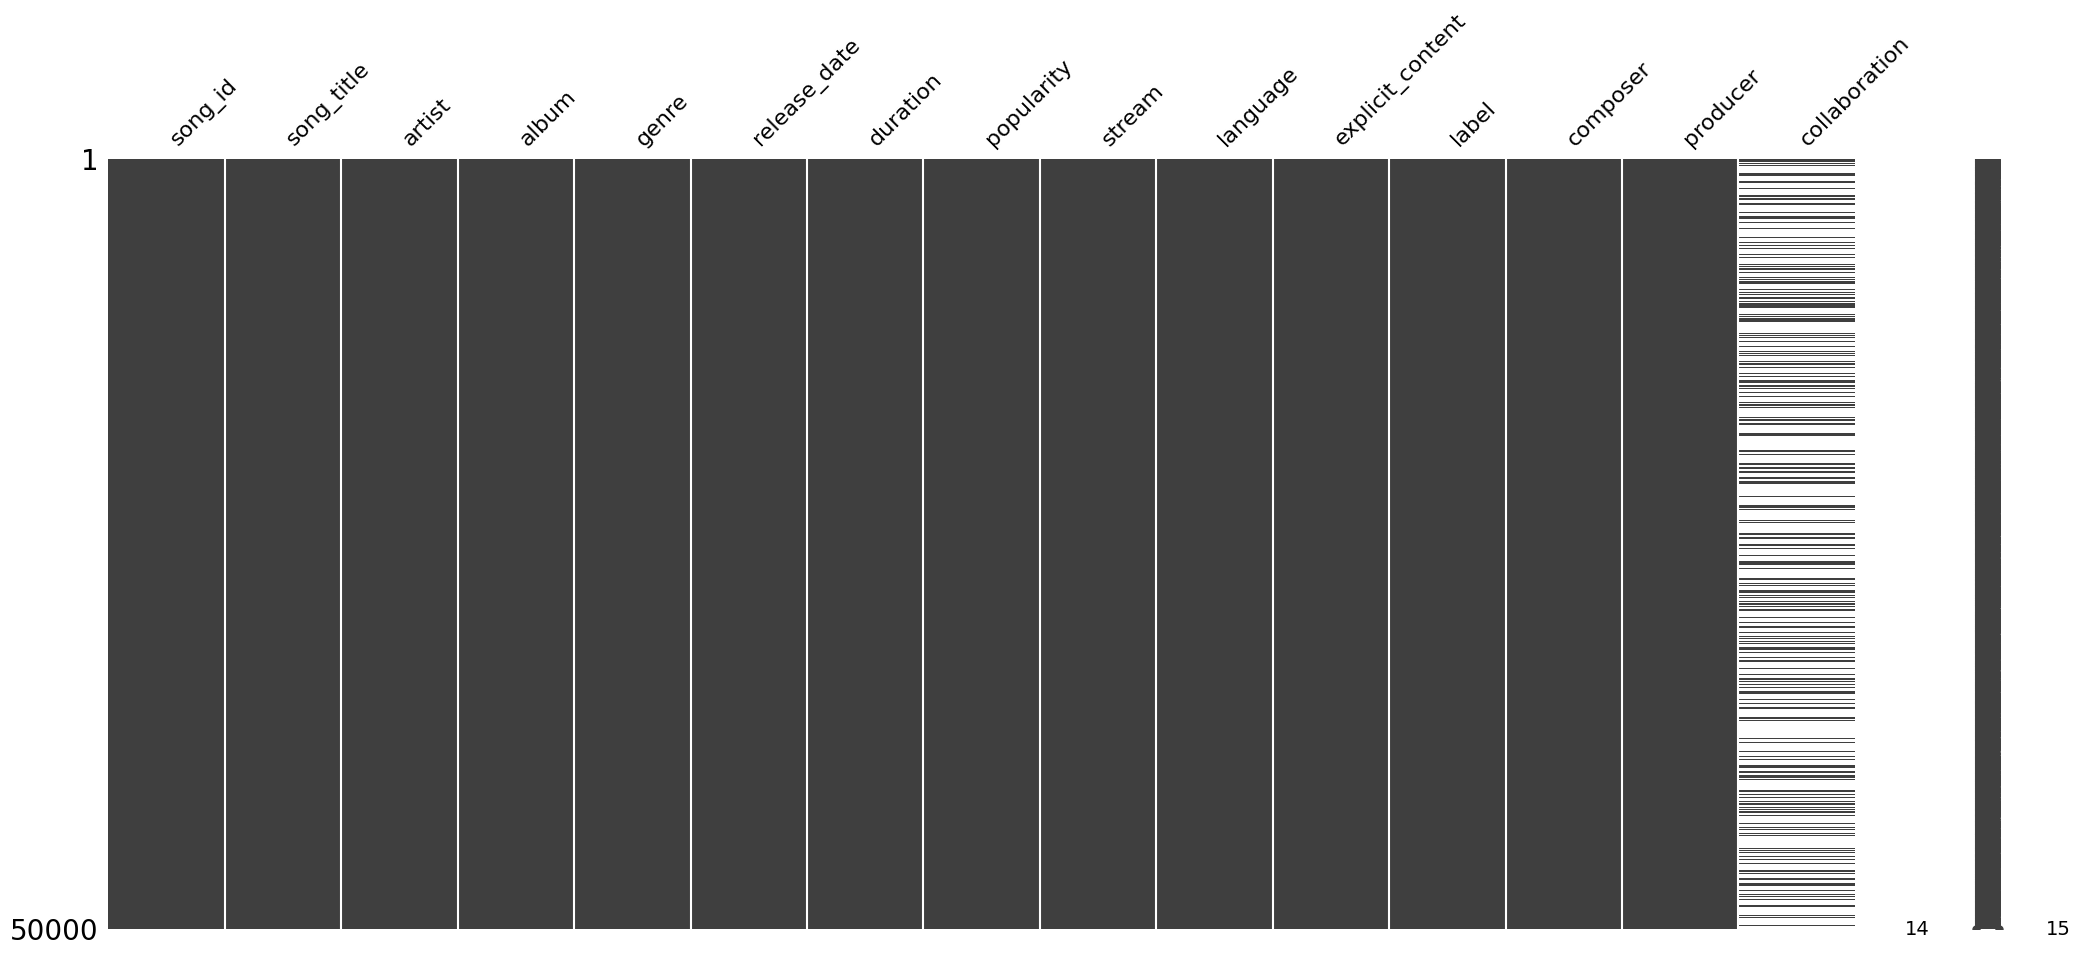

In [ ]:
msno.matrix(df);

# Verificação de Nulos e Remoção da Coluna `collaboration`

In [ ]:
df.collaboration.isnull().sum()

np.int64(35000)

In [ ]:
df = df.drop('collaboration', axis=1)
df.head()

,song_id,song_title,artist,album,genre,release_date,duration,popularity,stream,language,explicit_content,label,composer,producer
0,SP0001,Space Executive Series.,Sydney Clark,What.,Electronic,1997-11-08,282.0,42,35055874,English,Yes,Def Jam,Amy Hatfield,Jeffrey Weaver
1,SP0002,Price Last Painting.,Connor Peters DDS,Nature Politics.,Electronic,2015-05-10,127.0,50,9249527,English,Yes,Universal Music,Jason Gregory,Kenneth White
2,SP0003,Piece.,Anna Keith,Visit.,Pop,2024-07-08,239.0,10,76669110,English,Yes,Universal Music,Rachel Lopez,Jason Barnes
3,SP0004,Power Industry Your.,Zachary Simpson,Behavior Evening.,Hip-Hop,2022-08-15,214.0,86,34732016,English,No,Sony Music,Thomas Li,Mrs. Becky Palmer
4,SP0005,Food Animal Second.,Christopher Mcgee,Front.,Pop,2023-03-05,273.0,63,96649372,English,Yes,Def Jam,Adam Wagner,Beverly Baker


>  **Observação:** A coluna `collaboration` foi removida do conjunto de dados por apresentar um número elevado de valores ausentes e por não oferecer informações relevantes ou utilizáveis para os objetivos da análise. Como seu preenchimento era escasso e pouco representativo, sua manutenção poderia prejudicar a qualidade e consistência das etapas seguintes.

# Distribuição dos Gêneros Musicais no Dataset

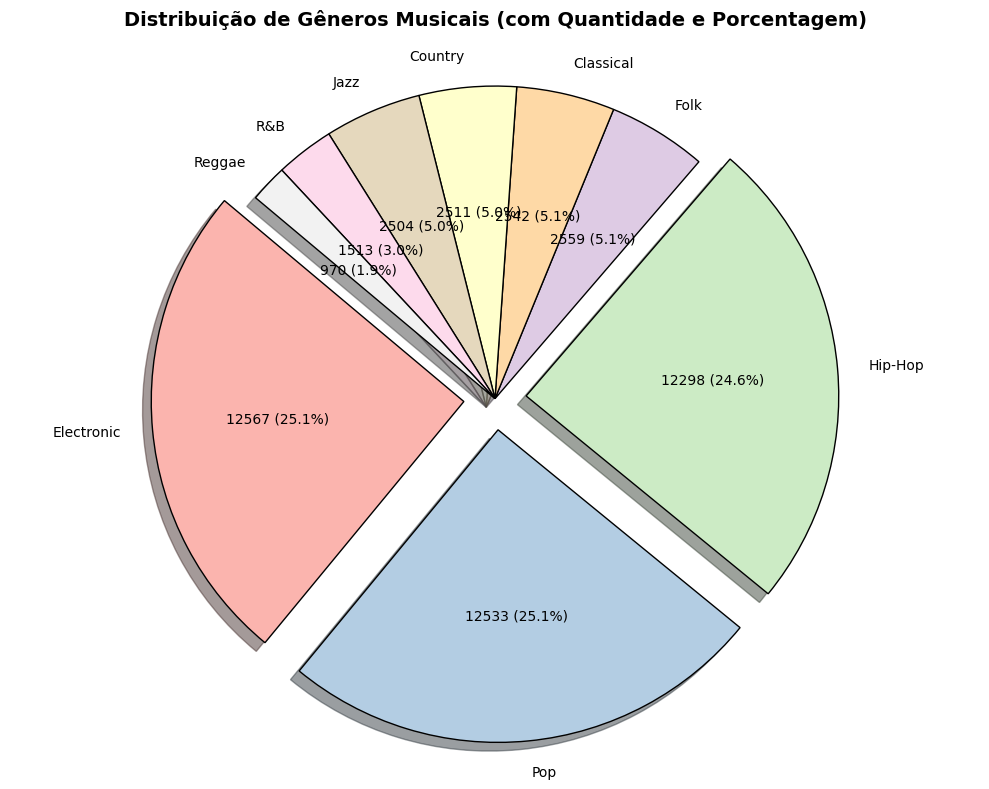

In [ ]:
genre_counts = df['genre'].value_counts()
labels = genre_counts.index
sizes = genre_counts.values

colors = plt.cm.Pastel1(np.linspace(0, 1, len(labels)))

explode = [0.1 if i < 3 else 0 for i in range(len(labels))]

plt.figure(figsize=(10, 8))

patches, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: f'{int(pct/100.*np.sum(sizes))} ({pct:.1f}%)',
    colors=colors,
    shadow=True,
    startangle=140,
    explode=explode,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')

plt.title('Distribuição de Gêneros Musicais (com Quantidade e Porcentagem)', fontsize=14, weight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

> **Observação:** O gráfico de pizza ilustra a distribuição dos gêneros musicais presentes no dataset. Os três gêneros mais frequentes foram destacados com realce (explode), facilitando a visualização de sua predominância em relação aos demais.


# Top 10 Cantores com Mais Músicas no Dataset

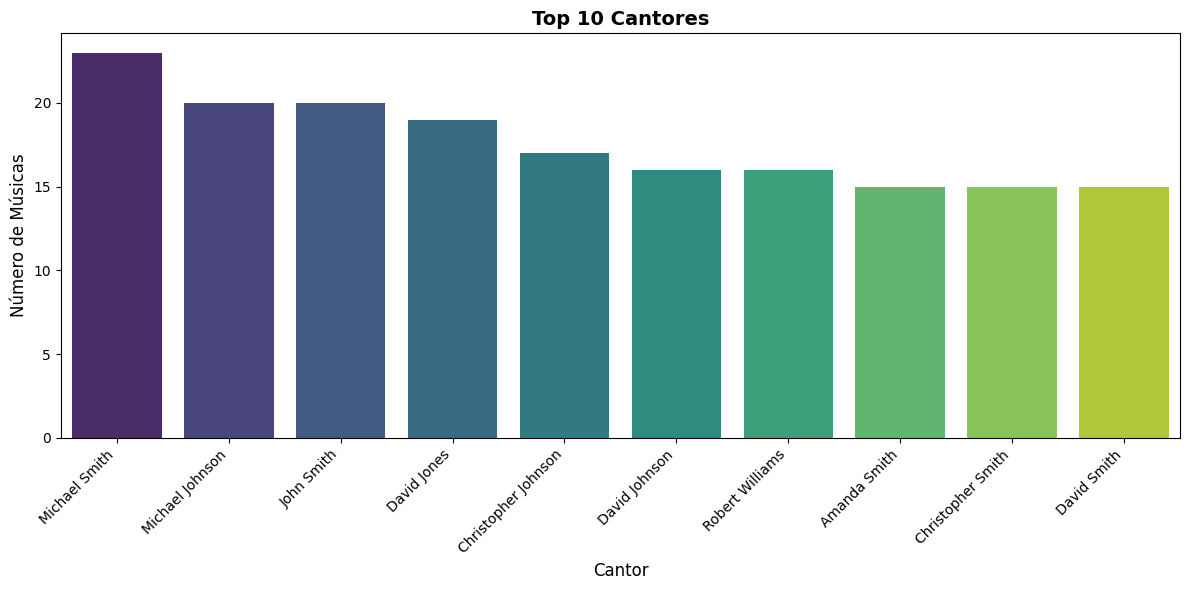

In [ ]:
top_10_artists = df['artist'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_artists.index, y=top_10_artists.values, palette='viridis')
plt.title('Top 10 Cantores', fontsize=14, weight='bold')
plt.xlabel('Cantor', fontsize=12)
plt.ylabel('Número de Músicas', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

> **Observação:** O gráfico de barras apresenta os 10 artistas com maior número de músicas no conjunto de dados, permitindo identificar os principais contribuintes para o acervo analisado.


# Distribuição dos Idiomas das Músicas

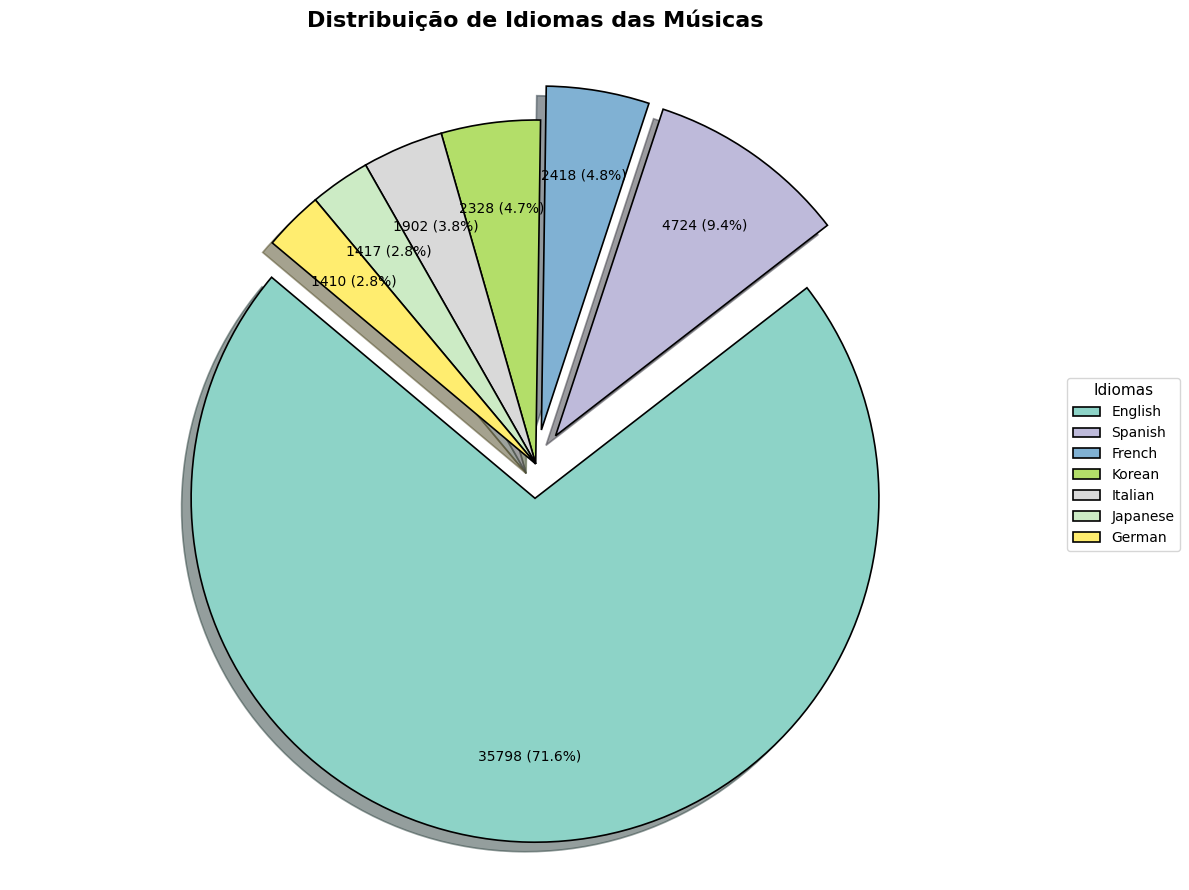

In [ ]:
language_counts = df['language'].value_counts()
labels_lang = language_counts.index
sizes_lang = language_counts.values

colors_lang = plt.cm.Set3(np.linspace(0, 1, len(labels_lang)))

explode_lang = [0.1 if i < 3 else 0 for i in range(len(labels_lang))]

plt.figure(figsize=(12, 9))

def custom_autopct(pct, allvals):
    absolute = int(pct / 100. * np.sum(allvals))
    return f'{absolute} ({pct:.1f}%)' if pct > 2 else ''

patches_lang, texts_lang, autotexts_lang = plt.pie(
    sizes_lang,
    labels=None,
    autopct=lambda pct: custom_autopct(pct, sizes_lang),
    colors=colors_lang,
    shadow=True,
    startangle=140,
    explode=explode_lang,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.2},
    pctdistance=0.75
)

for autotext in autotexts_lang:
    autotext.set_fontsize(10)
    autotext.set_color('black')

plt.legend(
    patches_lang,
    labels_lang,
    title="Idiomas",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title_fontsize=11
)

plt.title('Distribuição de Idiomas das Músicas', fontsize=16, weight='bold', pad=15)
plt.axis('equal')
plt.tight_layout()
plt.show()


> **Observação:** O gráfico de pizza apresenta a distribuição dos idiomas das músicas no dataset. Apenas os idiomas que representam mais de 2% do total exibem a contagem e a porcentagem, para melhor legibilidade. Os três idiomas mais frequentes foram destacados com efeito de explosão (explode).


# Distribuição das Músicas Populares (Popularidade > 80) por Gênero

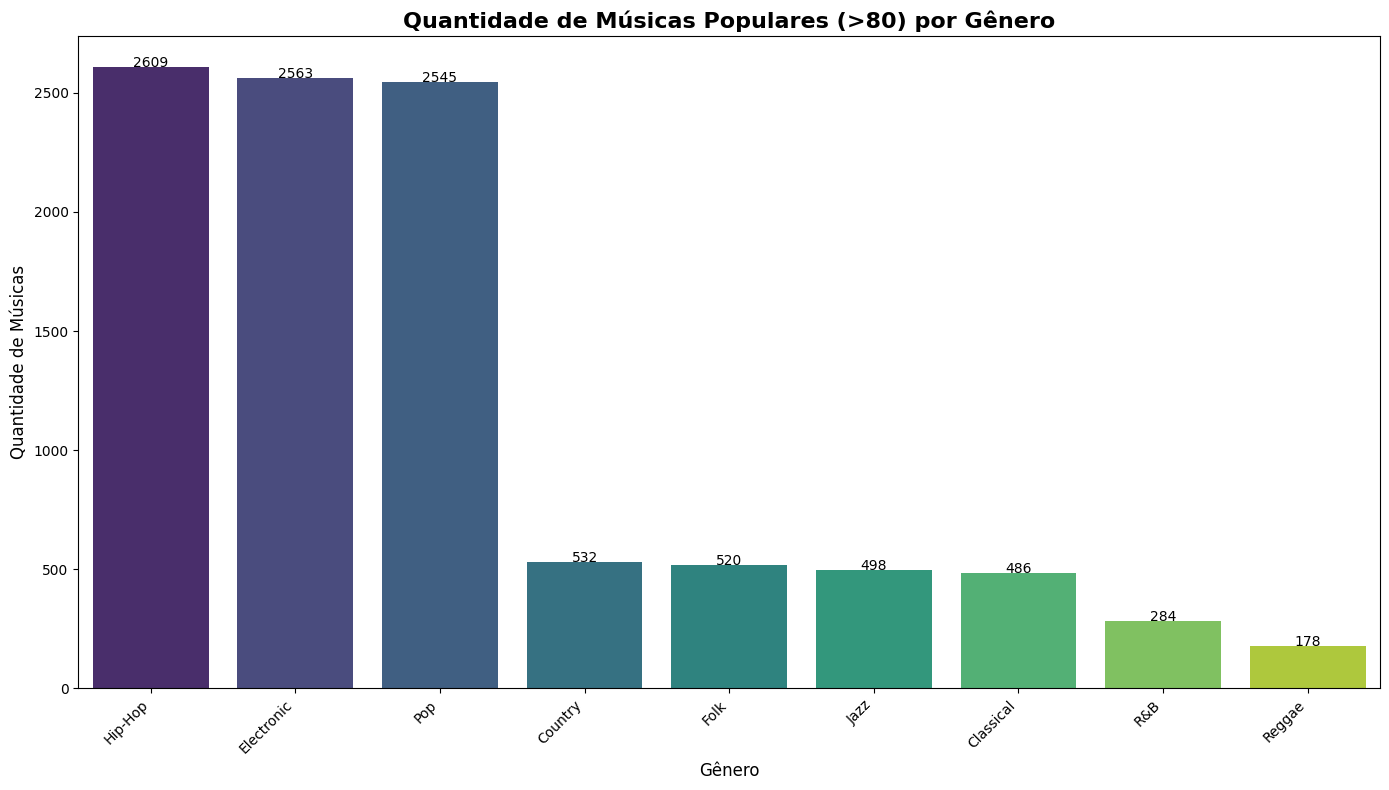

In [ ]:
df_popular = df[df['popularity'] > 80]

genre_counts_popular = df_popular['genre'].value_counts().reset_index()
genre_counts_popular.columns = ['genre', 'count']

plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='genre', y='count', data=genre_counts_popular, palette='viridis')

for index, row in genre_counts_popular.iterrows():
    barplot.text(index, row['count'], row['count'], color='black', ha="center")

plt.title('Quantidade de Músicas Populares (>80) por Gênero', fontsize=16, weight='bold')
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Quantidade de Músicas', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


> **Observação:** O gráfico de barras mostra a quantidade de músicas com popularidade acima de 80, segmentadas por gênero musical. Essa análise ajuda a identificar quais gêneros dominam entre as faixas mais populares do dataset.

# Evolução da Popularidade Média das Músicas ao Longo dos Anos

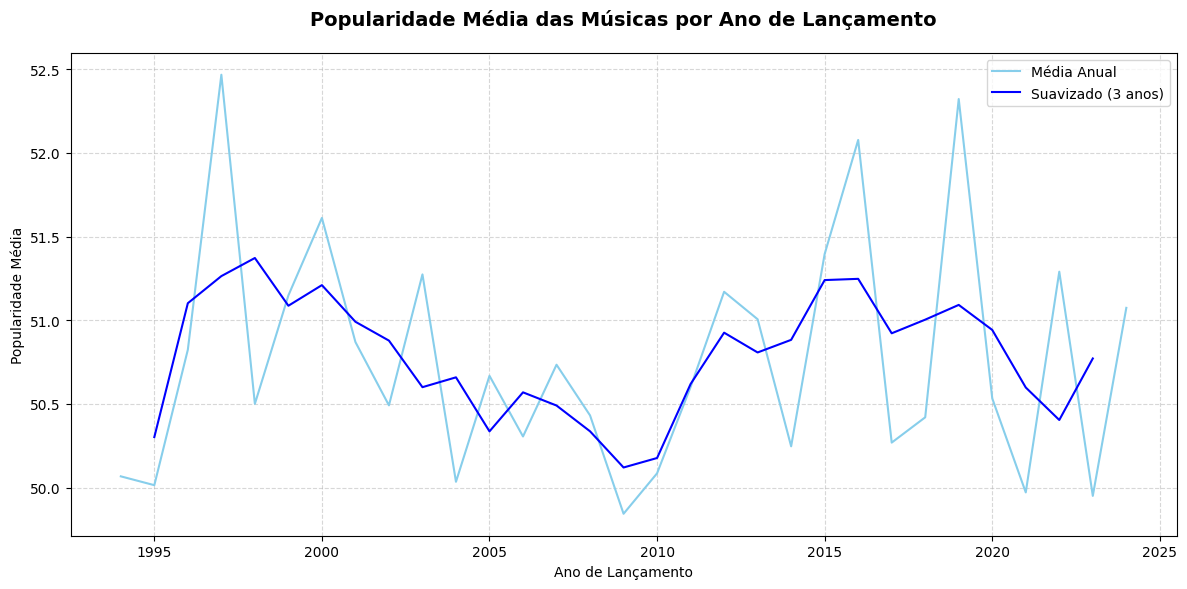

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df['release_year'] = df['release_date'].dt.year

df_yearly = df[df['release_year'].between(1950, 2025)]

yearly_popularity = df_yearly.groupby('release_year')['popularity'].mean().reset_index()

yearly_popularity['popularity_smooth'] = yearly_popularity['popularity'].rolling(window=3, center=True).mean()

plt.figure(figsize=(12,6))
sns.lineplot(x='release_year', y='popularity', data=yearly_popularity, label='Média Anual', color='skyblue')
sns.lineplot(x='release_year', y='popularity_smooth', data=yearly_popularity, label='Suavizado (3 anos)', color='blue')

plt.title('Popularidade Média das Músicas por Ano de Lançamento', fontsize=14, weight='bold', pad=20)
plt.xlabel('Ano de Lançamento')
plt.ylabel('Popularidade Média')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


>  **Observação:** O gráfico de linha apresenta a popularidade média das músicas por ano de lançamento, com uma curva suavizada para evidenciar tendências mais consistentes ao longo do tempo. A análise considera músicas lançadas entre 1990 e 2025.


# Top 10 Álbuns com Maior Número de Streams

Top 10 Álbuns por Stream:
                 album              artist     stream
44851           Today.     Robert Williams  177448826
48051           While.        Thomas Davis  148377336
12024           Dream.        Joshua Smith  116527102
22541            Late.       Michael Brown  112238234
29821             Our.       Michael Clark  100385797
38644         Similar.  Catherine Anderson   99999128
5175          Billion.        Selena Perez   99998468
2570   Appear Trouble.        Thomas Roach   99996451
44229      Those Task.    Jason Strickland   99993859
12285     Each Season.      Monica Stevens   99992156


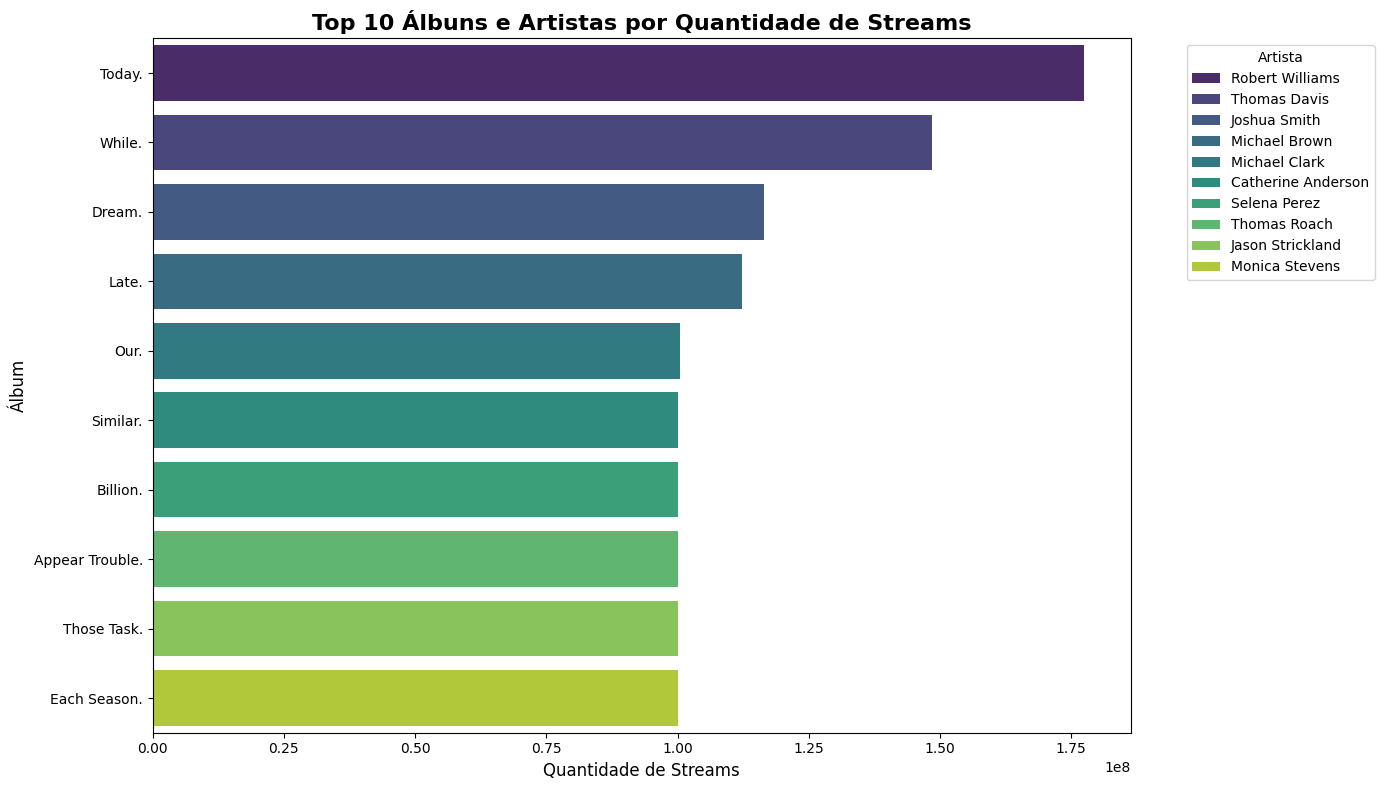

In [ ]:
album_streams = df.groupby(['album', 'artist'])['stream'].sum().reset_index()

top_10_albums_by_streams = album_streams.sort_values(by='stream', ascending=False).head(10)

print("Top 10 Álbuns por Stream:")
print(top_10_albums_by_streams)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_10_albums_by_streams,
    x='stream',
    y='album',
    hue='artist',
    dodge=False,
    palette='viridis'
)

plt.title('Top 10 Álbuns e Artistas por Quantidade de Streams', fontsize=16, weight='bold')
plt.xlabel('Quantidade de Streams', fontsize=12)
plt.ylabel('Álbum', fontsize=12)
plt.legend(title='Artista', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


>  **Observação:** Este gráfico de barras mostra os 10 álbuns com maior soma de streams, incluindo o artista correspondente para cada álbum. A visualização permite identificar quais álbuns e artistas dominam o consumo musical em termos de streaming.


# Distribuição das Músicas por Gravadora (Top 15 Labels)

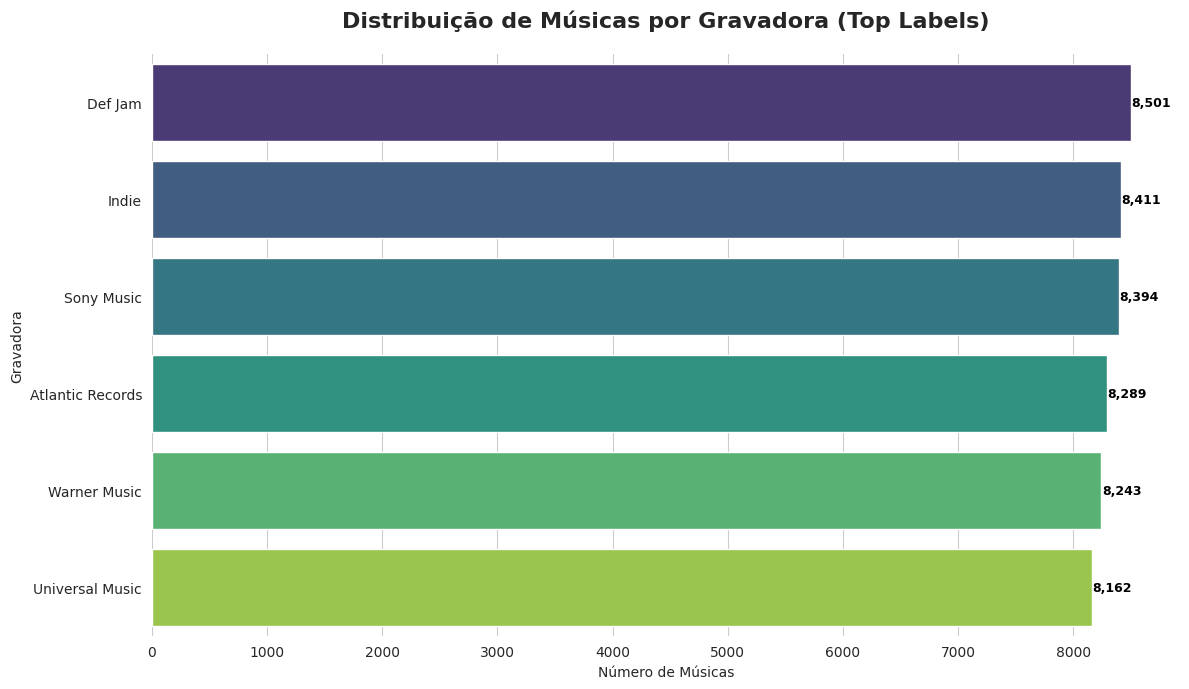

In [ ]:
label_count = df.label.value_counts()
label_count_sorted = label_count.sort_values(ascending=False)[:15]

colors = sns.color_palette("viridis", len(label_count_sorted))

plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

ax = sns.barplot(
    x=label_count_sorted.values,
    y=label_count_sorted.index,
    palette=colors
)

for i, v in enumerate(label_count_sorted.values):
    ax.text(v + 5, i, f'{v:,}', color='black', va='center', fontsize=9, weight='bold')

plt.title('Distribuição de Músicas por Gravadora (Top Labels)', fontsize=16, weight='bold', pad=20)
plt.xlabel('Número de Músicas')
plt.ylabel('Gravadora')

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


> **Observação:** O gráfico apresenta as 15 gravadoras com maior número de músicas no dataset. A visualização evidencia quais labels têm maior presença, contribuindo para a compreensão do mercado musical representado.


# Popularidade e Streams Médios por Gênero Musical (Top 10)

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'])

            popularity        stream  count
genre                                      
Country      51.661888  5.046560e+07   2511
Folk         51.467370  5.048961e+07   2559
Hip-Hop      50.918117  5.021347e+07  12298
Electronic   50.853517  5.021413e+07  12568
Pop          50.684059  4.991478e+07  12534
Jazz         50.431310  4.969095e+07   2504
R&B          50.335096  5.097805e+07   1513
Reggae       49.954686  5.141851e+07    971
Classical    49.649489  5.032964e+07   2542


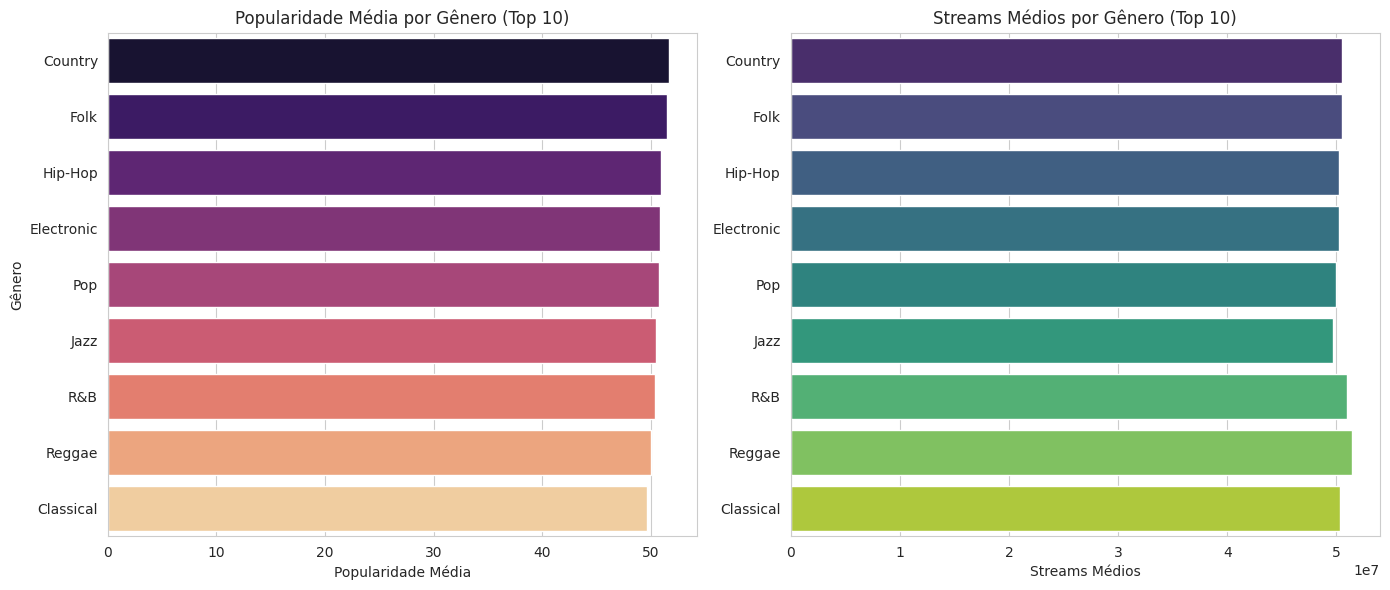

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

genre_stats = df.groupby('genre').agg({
    'popularity': 'mean',
    'stream': 'mean',
    'song_id': 'count'
}).rename(columns={'song_id': 'count'}).sort_values(by='popularity', ascending=False)

print(genre_stats.head(10))

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.barplot(x=genre_stats.head(10).popularity, y=genre_stats.head(10).index, palette='magma')
plt.title('Popularidade Média por Gênero (Top 10)')
plt.xlabel('Popularidade Média')
plt.ylabel('Gênero')

plt.subplot(1,2,2)
sns.barplot(x=genre_stats.head(10).stream, y=genre_stats.head(10).index, palette='viridis')
plt.title('Streams Médios por Gênero (Top 10)')
plt.xlabel('Streams Médios')
plt.ylabel('')

plt.tight_layout()
plt.show()


> **Observação:** Os gráficos apresentam, lado a lado, a popularidade média e o número médio de streams para os 10 gêneros mais populares do dataset. Essa análise ajuda a entender quais gêneros têm maior engajamento e audiência.


# Evolução da Popularidade Média e Streams Médios ao Longo dos Anos


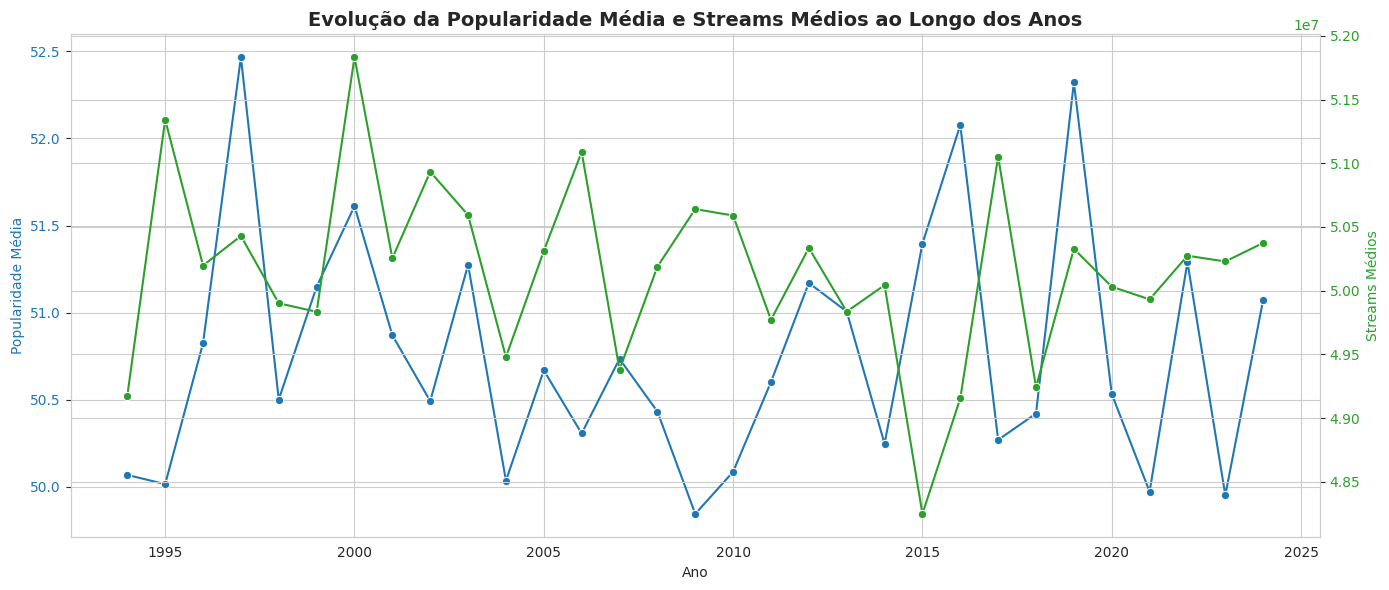

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.dropna(subset=['release_date'])
df['year'] = df['release_date'].dt.year

year_stats = df.groupby('year').agg({
    'popularity': 'mean',
    'stream': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(14,6))

color = 'tab:blue'
ax1.set_xlabel('Ano')
ax1.set_ylabel('Popularidade Média', color=color)
sns.lineplot(data=year_stats, x='year', y='popularity', marker='o', ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Streams Médios', color=color)
sns.lineplot(data=year_stats, x='year', y='stream', marker='o', ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Evolução da Popularidade Média e Streams Médios ao Longo dos Anos', fontsize=14, weight='bold')
fig.tight_layout()
plt.show()


>  **Observação:** O gráfico apresenta a evolução conjunta da popularidade média e dos streams médios das músicas ao longo dos anos. O uso de dois eixos y permite comparar as tendências dessas duas métricas ao longo do tempo.


#Análise da Participação e Popularidade de Artistas Novos ao Longo dos Anos


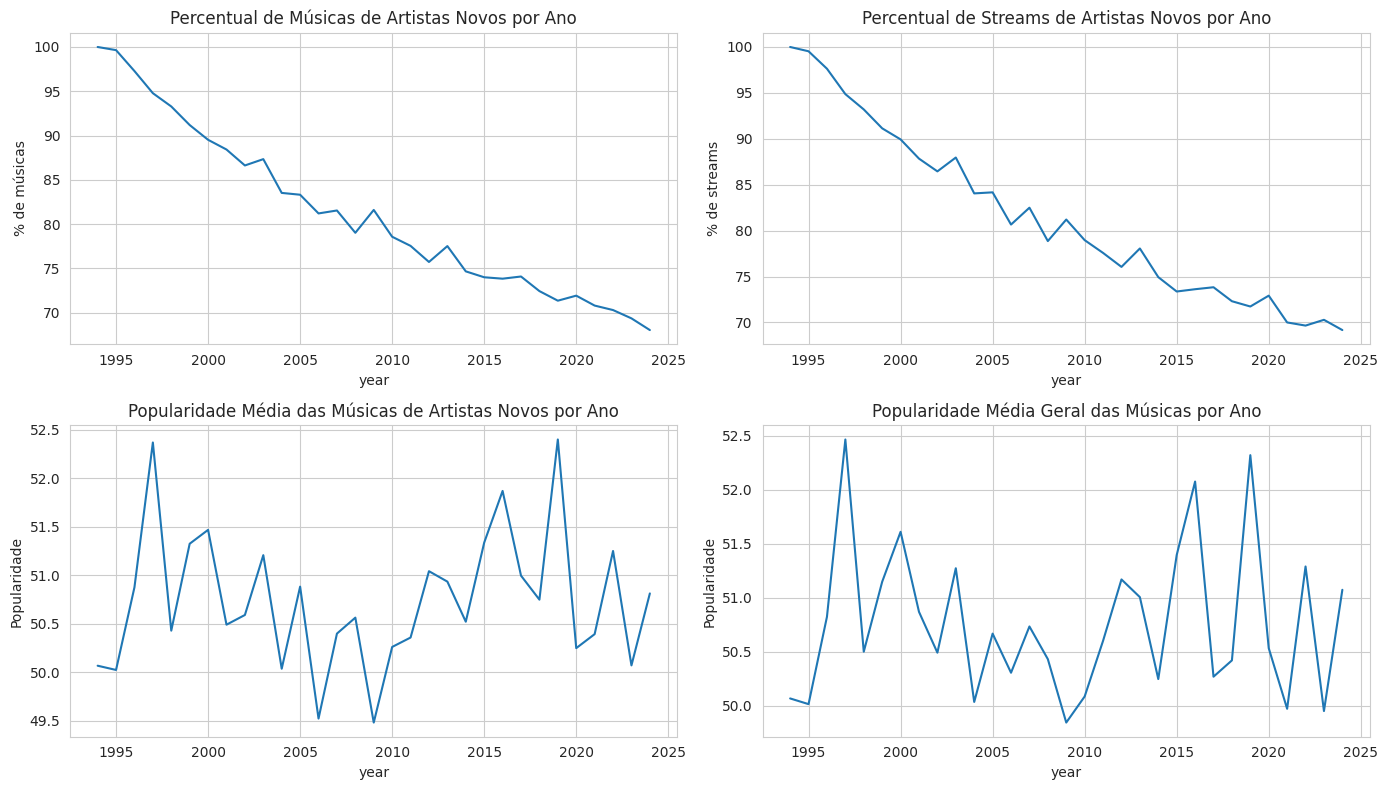

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.dropna(subset=['release_date'])
df['year'] = df['release_date'].dt.year

first_appearance = df.groupby('artist')['year'].min().reset_index()
first_appearance.columns = ['artist', 'first_year']

df = df.merge(first_appearance, on='artist')

df['is_new_artist'] = df['year'] == df['first_year']

yearly_stats = df.groupby('year').agg(
    total_songs=('song_id', 'count'),
    new_artist_songs=('is_new_artist', 'sum'),
    total_streams=('stream', 'sum'),
    new_artist_streams=('stream', lambda x: x[df.loc[x.index, 'is_new_artist']].sum()),
    avg_popularity=('popularity', 'mean'),
    new_artist_avg_popularity=('popularity', lambda x: x[df.loc[x.index, 'is_new_artist']].mean())
).reset_index()

yearly_stats['pct_new_artist_songs'] = yearly_stats['new_artist_songs'] / yearly_stats['total_songs'] * 100
yearly_stats['pct_new_artist_streams'] = yearly_stats['new_artist_streams'] / yearly_stats['total_streams'] * 100

plt.figure(figsize=(14, 8))

plt.subplot(2,2,1)
sns.lineplot(data=yearly_stats, x='year', y='pct_new_artist_songs')
plt.title('Percentual de Músicas de Artistas Novos por Ano')
plt.ylabel('% de músicas')

plt.subplot(2,2,2)
sns.lineplot(data=yearly_stats, x='year', y='pct_new_artist_streams')
plt.title('Percentual de Streams de Artistas Novos por Ano')
plt.ylabel('% de streams')

plt.subplot(2,2,3)
sns.lineplot(data=yearly_stats, x='year', y='new_artist_avg_popularity')
plt.title('Popularidade Média das Músicas de Artistas Novos por Ano')
plt.ylabel('Popularidade')

plt.subplot(2,2,4)
sns.lineplot(data=yearly_stats, x='year', y='avg_popularity')
plt.title('Popularidade Média Geral das Músicas por Ano')
plt.ylabel('Popularidade')

plt.tight_layout()
plt.show()


> **Observação:** Este conjunto de gráficos apresenta a evolução do percentual de músicas e streams atribuídos a artistas novos, assim como a popularidade média das músicas desses artistas em comparação com a média geral. A análise ajuda a entender o impacto e a relevância dos artistas recém-chegados ao longo do tempo.

# Análise de Correlação entre Variáveis Numéricas e Categóricas

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year

features = ['language', 'genre', 'duration', 'year']

df_dummies = pd.get_dummies(df[features], columns=['language', 'genre'], drop_first=True, dtype=int)
df_dummies.head()

,duration,year,language_French,language_German,language_Italian,language_Japanese,language_Korean,language_Spanish,genre_Country,genre_Electronic,genre_Folk,genre_Hip-Hop,genre_Jazz,genre_Pop,genre_R&B,genre_Reggae
0,282.0,1997,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,127.0,2015,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,239.0,2024,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,214.0,2022,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,273.0,2023,0,0,0,0,0,0,0,0,0,0,0,1,0,0


<Axes: >

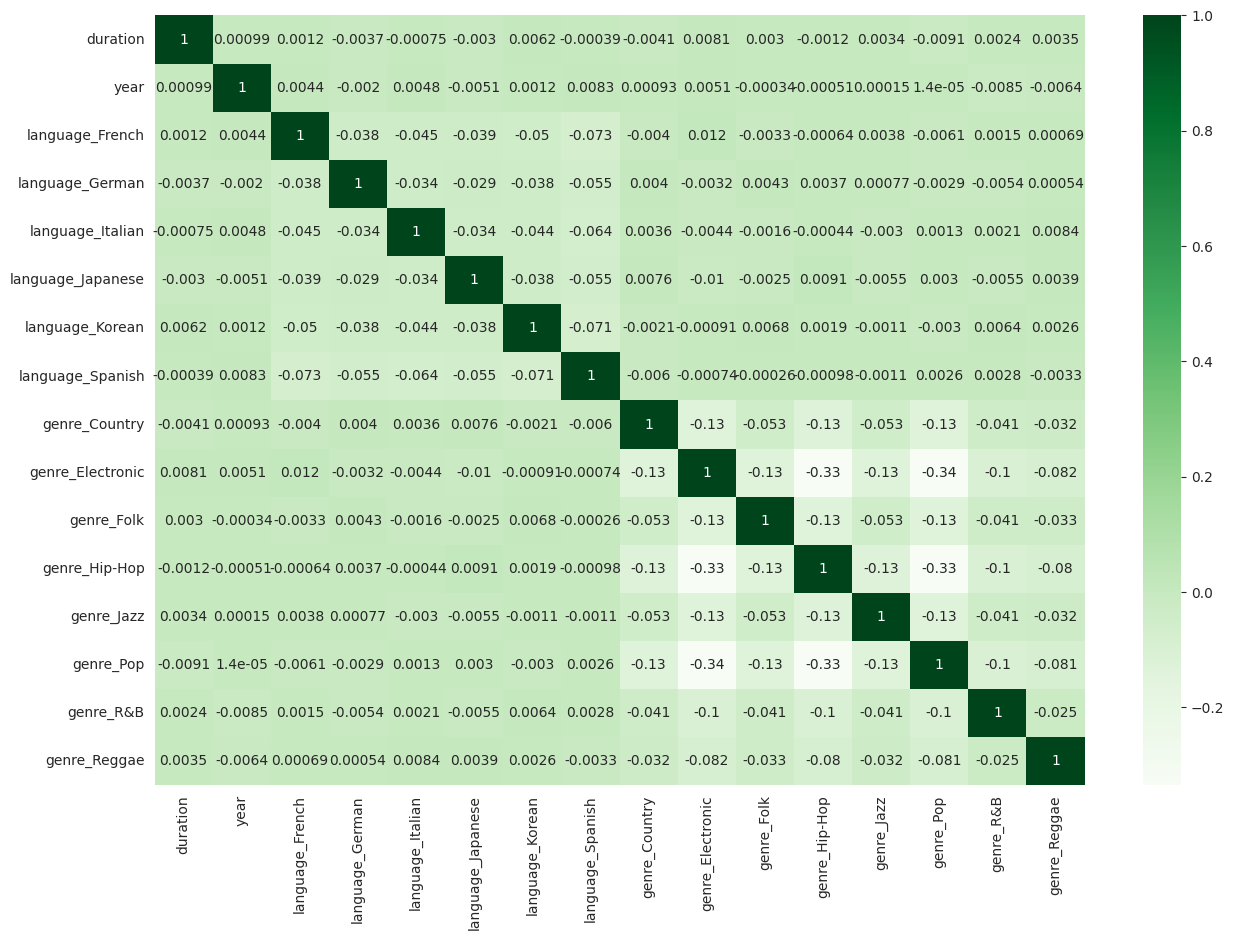

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df_dummies.corr(numeric_only=True), annot=True, cmap='Greens')

In [ ]:
# Copia o dataframe para não mexer no original
df_corr = df.copy()

# Lista de colunas categóricas
categorical_cols = ['artist', 'genre', 'label', 'composer', 'producer']

# Label Encoding para cada coluna
for col in categorical_cols:
    le = LabelEncoder()
    df_corr[col + '_encoded'] = le.fit_transform(df_corr[col].astype(str))

# Criação de dataframe apenas com as variáveis numéricas + as codificadas
cols_for_corr = ['popularity', 'stream', 'duration'] + [col + '_encoded' for col in categorical_cols]

# Calcula a correlação
correlation_matrix = df_corr[cols_for_corr].corr()

# Correlação de cada feature com a Popularity
print(correlation_matrix['popularity'].sort_values(ascending=False))


popularity          1.000000
composer_encoded    0.004502
artist_encoded      0.003403
duration            0.000217
stream             -0.000579
producer_encoded   -0.000881
genre_encoded      -0.002521
label_encoded      -0.008017
Name: popularity, dtype: float64


> **Observação:** Esta seção realiza a codificação de variáveis categóricas para possibilitar a análise de correlação com as variáveis numéricas, especialmente com a popularidade. O mapa de calor apresenta as correlações entre as variáveis binarizadas e numéricas, enquanto a tabela exibe as correlações ordenadas com a popularidade.


# Conclusão

A análise revelou insights valiosos sobre a composição do dataset e as características que influenciam a popularidade das músicas no Spotify. Foi possível observar padrões claros em gêneros musicais, idiomas predominantes, e a crescente importância dos artistas novos no mercado.

Entretanto, a construção do modelo preditivo para estimar a popularidade das músicas enfrentou dificuldades significativas, provavelmente devido à complexidade intrínseca da variável target, a presença de ruídos nos dados e limitações nas features disponíveis. Esses desafios indicam que prever popularidade musical exige abordagens mais avançadas, dados adicionais ou diferentes técnicas de modelagem.